Goal: To understand list of Gradient Descent Techniques in detail

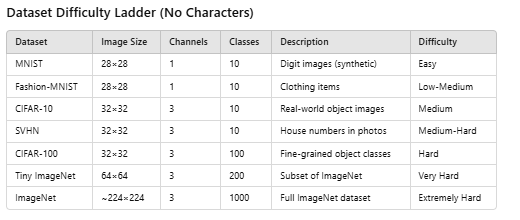

**1. Start with MNIST (Hardwritten Digit Classifications)**

Total Training Samples: 60000; Total Test Samples: 10000


Training with optimizer: GD
Epoch [1/5] J(θ) = 2.2926
Epoch [2/5] J(θ) = 2.3080
Epoch [3/5] J(θ) = 2.3167
Epoch [4/5] J(θ) = 2.2967
Epoch [5/5] J(θ) = 2.3090

Training with optimizer: SGD

Epoch 1 (Optimizer: SGD)
  ∇J(conv1.weight) = grad norm: 0.022044
  ∇J(conv1.bias) = grad norm: 0.009998
  ∇J(conv2.weight) = grad norm: 0.120499
  ∇J(conv2.bias) = grad norm: 0.037005
  ∇J(fc1.weight) = grad norm: 0.241853
  ∇J(fc1.bias) = grad norm: 0.065955
  ∇J(fc2.weight) = grad norm: 0.086044
  ∇J(fc2.bias) = grad norm: 0.142814
Epoch [1/5] J(θ) = 1.4147

Epoch 2 (Optimizer: SGD)
  ∇J(conv1.weight) = grad norm: 0.084576
  ∇J(conv1.bias) = grad norm: 0.182728
  ∇J(conv2.weight) = grad norm: 0.516141
  ∇J(conv2.bias) = grad norm: 0.074766
  ∇J(fc1.weight) = grad norm: 5.643419
  ∇J(fc1.bias) = grad norm: 0.095816
  ∇J(fc2.weight) = grad norm: 4.462295
  ∇J(fc2.bias) = grad norm: 0.175554
Epoch [2/5] J(θ) = 0.3455

Epoch 3 (Optimizer: SGD)
  ∇J(conv1.weight) = grad norm: 0.086136
  ∇J(conv1.bias)

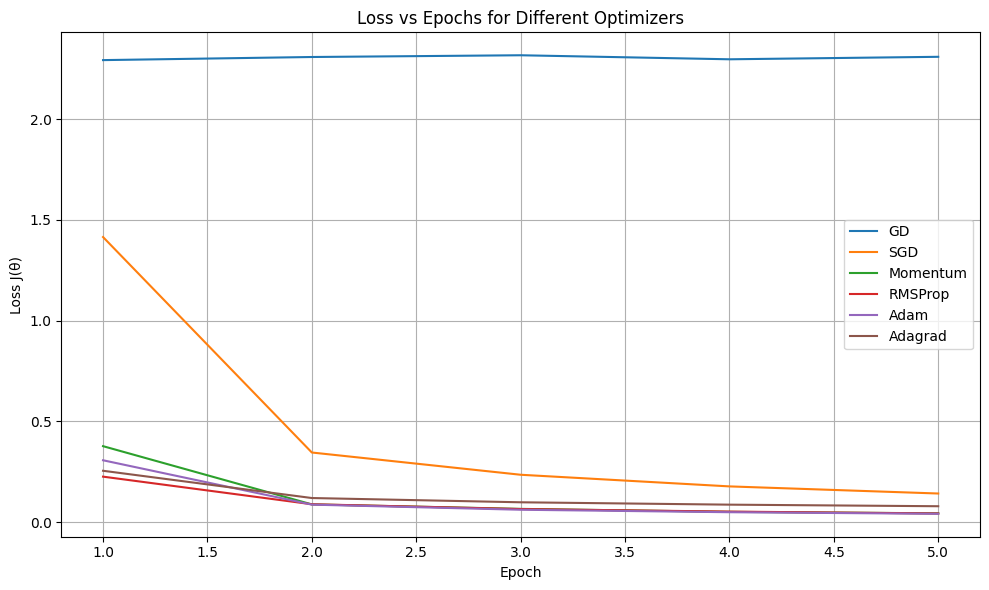

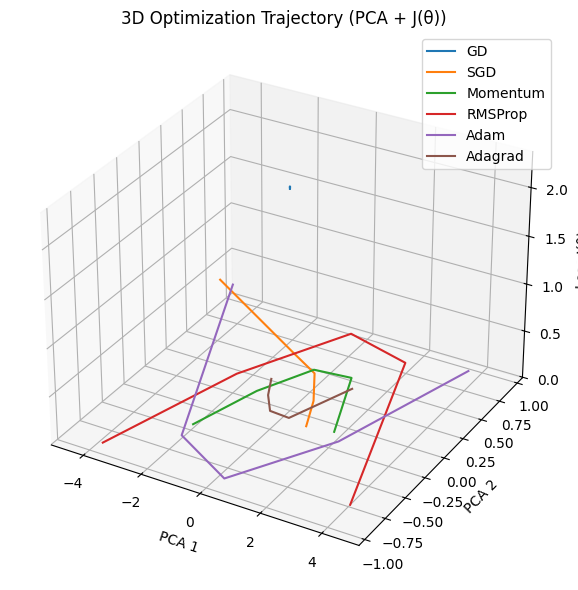


Final Test Accuracy: 97.82%


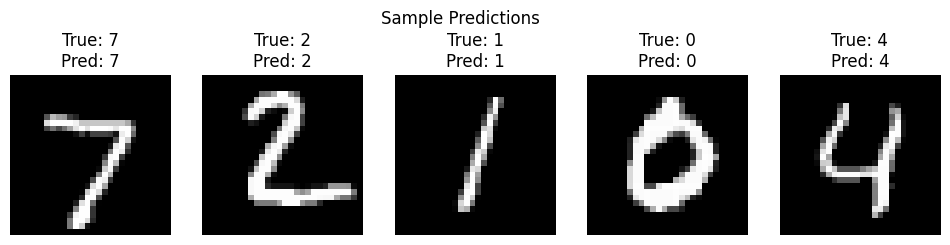

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import random

# Set seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(16*5*5, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Utility functions
def get_param_vector(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def predict_samples(model, dataset, num=5):
    model.eval()
    fig, axes = plt.subplots(1, num, figsize=(12, 3))
    for i in range(num):
        image, label = dataset[i]
        input_img = image.unsqueeze(0)
        output = model(input_img)
        pred = torch.argmax(output, dim=1).item()
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"True: {label}\nPred: {pred}")
        axes[i].axis('off')
    plt.suptitle("Sample Predictions")
    plt.show()

# Train model and print internal state
def train_and_track(optimizer_name, model, train_loader, criterion, epochs=5):
    model.train()
    param_trajectory = []
    loss_trajectory = []

    if optimizer_name == 'GD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        use_batches = False
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        use_batches = True
    elif optimizer_name == 'Momentum':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        use_batches = True
    elif optimizer_name == 'RMSProp':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
        use_batches = True
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        use_batches = True
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
        use_batches = True
    else:
        raise ValueError("Unsupported optimizer")

    print(f"\nTraining with optimizer: {optimizer_name}")
    for epoch in range(epochs):
        running_loss = 0.0
        first_batch = True

        if not use_batches:
            images, labels = next(iter(train_loader))
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss = loss.item()
        else:
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()

                if first_batch:
                    print(f"\nEpoch {epoch+1} (Optimizer: {optimizer_name})")
                    for name, param in model.named_parameters():
                        if param.grad is not None:
                            print(f"  ∇J({name}) = grad norm: {param.grad.norm():.6f}")
                    for group in optimizer.param_groups:
                        for p in group['params']:
                            state = optimizer.state[p]
                            if optimizer_name == 'Momentum' and 'momentum_buffer' in state:
                                v = state['momentum_buffer']
                                print(f"  v (momentum) mean: {v.mean().item():.6f}")
                            if optimizer_name == 'RMSProp' and 'square_avg' in state:
                                s = state['square_avg']
                                print(f"  s (RMSProp avg^2) mean: {s.mean().item():.6f}")
                            if optimizer_name == 'Adam' and 'exp_avg' in state:
                                m = state['exp_avg']
                                v = state['exp_avg_sq']
                                print(f"  mₜ (Adam 1st moment) mean: {m.mean().item():.6f}")
                                print(f"  vₜ (Adam 2nd moment) mean: {v.mean().item():.6f}")
                            if optimizer_name == 'Adagrad' and 'sum' in state:
                                G = state['sum']
                                print(f"  Gₜ (Adagrad sum of grads²) mean: {G.mean().item():.6f}")
                    first_batch = False

                optimizer.step()
                running_loss += loss.item()

        avg_loss = running_loss / (1 if not use_batches else len(train_loader))
        print(f"Epoch [{epoch+1}/{epochs}] J(θ) = {avg_loss:.4f}")

        param_vector = get_param_vector(model).detach().cpu().numpy()
        param_trajectory.append(param_vector)
        loss_trajectory.append(avg_loss)

    return np.array(param_trajectory), np.array(loss_trajectory), model

# Accuracy eval
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Run training for all optimizers
optimizers = ['GD', 'SGD', 'Momentum', 'RMSProp', 'Adam', 'Adagrad']
trajectories = {}
criterion = nn.CrossEntropyLoss()

for opt_name in optimizers:
    model = SimpleCNN()
    traj, losses, trained_model = train_and_track(opt_name, model, train_loader, criterion, epochs=5)
    trajectories[opt_name] = {'trajectory': traj, 'losses': losses, 'model': trained_model}

# 2D Loss plot
plt.figure(figsize=(10, 6))
for opt_name in optimizers:
    losses = trajectories[opt_name]['losses']
    plt.plot(range(1, len(losses)+1), losses, label=opt_name)
plt.xlabel('Epoch')
plt.ylabel('Loss J(θ)')
plt.title('Loss vs Epochs for Different Optimizers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3D PCA Trajectory
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for opt_name in optimizers:
    traj = trajectories[opt_name]['trajectory']
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(traj)
    z = trajectories[opt_name]['losses']
    ax.plot(reduced[:, 0], reduced[:, 1], z, label=opt_name)
ax.set_title('3D Optimization Trajectory (PCA + J(θ))')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('Loss J(θ)')
ax.legend()
plt.tight_layout()
plt.show()

# Final evaluation
accuracy = evaluate(trained_model, test_loader)
print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")
predict_samples(trained_model, test_dataset)

**Gradient Descent Variants — Theoretical Update Formulas**

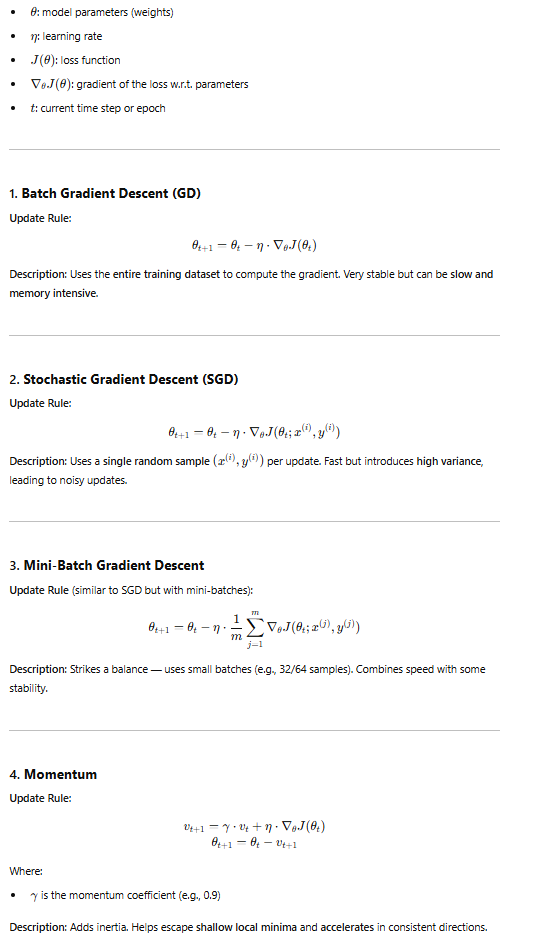

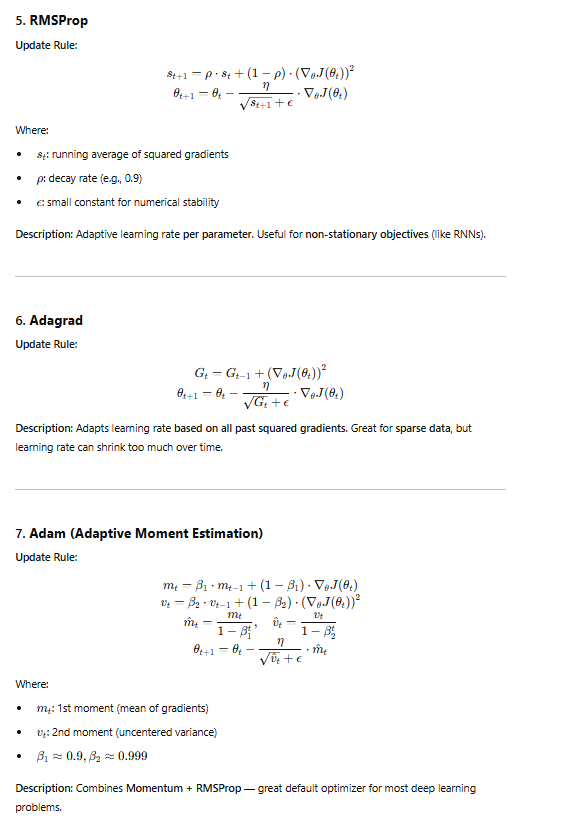

**Terms:**

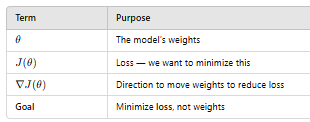

**What is loss here?**

It’s a numerical measure of how wrong our model’s predictions are.


In CNN above, we are using:  Softmax + negative log likelihood (nn.CrossEntropyLoss())

Softmax turns this into probabilities: Loss = - log(p_model(correct class))



Training with optimizer: GD
Epoch [1/5], Loss: 2.2926
Epoch [2/5], Loss: 2.3080
Epoch [3/5], Loss: 2.3167
Epoch [4/5], Loss: 2.2967
Epoch [5/5], Loss: 2.3090

Training with optimizer: SGD
Epoch [1/5], Loss: 1.4147
Epoch [2/5], Loss: 0.3455
Epoch [3/5], Loss: 0.2352
Epoch [4/5], Loss: 0.1774
Epoch [5/5], Loss: 0.1421

Training with optimizer: Momentum
Epoch [1/5], Loss: 0.3770
Epoch [2/5], Loss: 0.0881
Epoch [3/5], Loss: 0.0658
Epoch [4/5], Loss: 0.0511
Epoch [5/5], Loss: 0.0438

Training with optimizer: RMSProp
Epoch [1/5], Loss: 0.2257
Epoch [2/5], Loss: 0.0888
Epoch [3/5], Loss: 0.0650
Epoch [4/5], Loss: 0.0523
Epoch [5/5], Loss: 0.0431

Training with optimizer: Adam
Epoch [1/5], Loss: 0.3070
Epoch [2/5], Loss: 0.0869
Epoch [3/5], Loss: 0.0616
Epoch [4/5], Loss: 0.0493
Epoch [5/5], Loss: 0.0414

Training with optimizer: Adagrad
Epoch [1/5], Loss: 0.2549
Epoch [2/5], Loss: 0.1197
Epoch [3/5], Loss: 0.0985
Epoch [4/5], Loss: 0.0868
Epoch [5/5], Loss: 0.0790


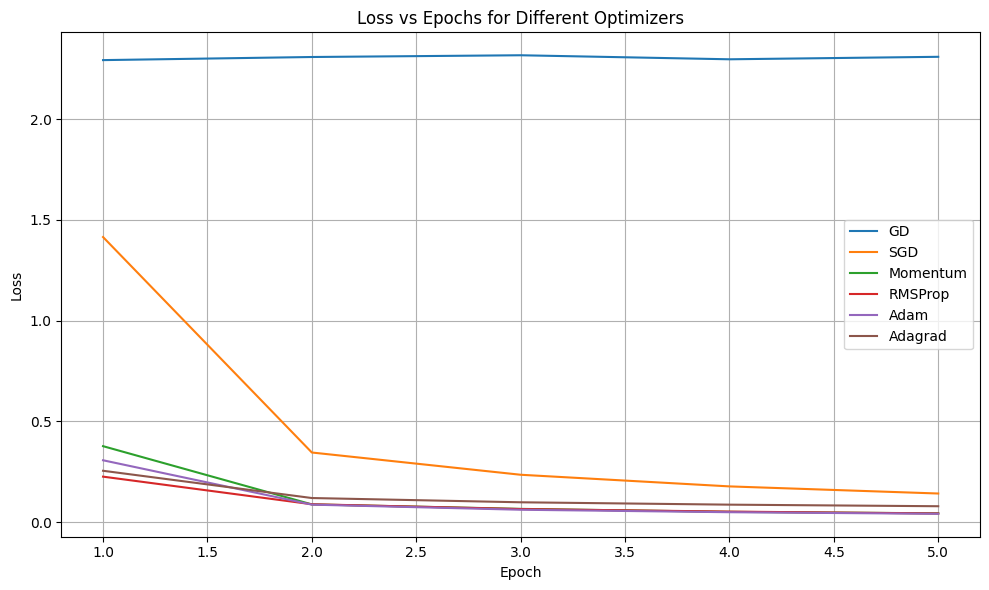

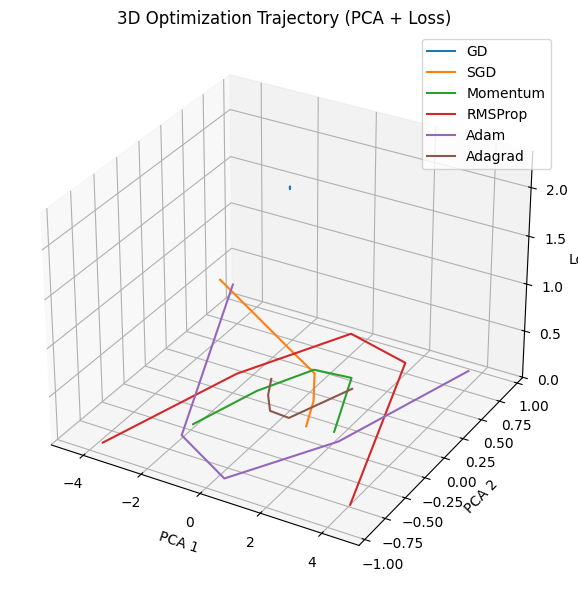


Test Accuracy: 97.82%


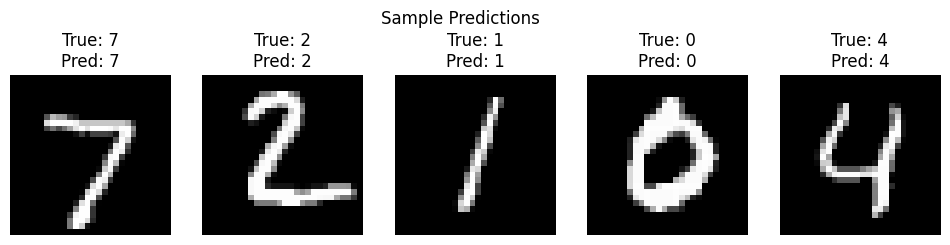

In [ ]:
# Re-import after kernel reset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import random

# Set seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Load data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(16*5*5, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Helper functions
def get_param_vector(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def predict_samples(model, dataset, num=5):
    model.eval()
    fig, axes = plt.subplots(1, num, figsize=(12, 3))
    for i in range(num):
        image, label = dataset[i]
        input_img = image.unsqueeze(0)
        output = model(input_img)
        pred = torch.argmax(output, dim=1).item()
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"True: {label}\nPred: {pred}")
        axes[i].axis('off')
    plt.suptitle("Sample Predictions")
    plt.show()

def train_and_track(optimizer_name, model, train_loader, criterion, epochs=5):
    model.train()
    param_trajectory = []
    loss_trajectory = []

    if optimizer_name == 'GD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        use_batches = False
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        use_batches = True
    elif optimizer_name == 'Momentum':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        use_batches = True
    elif optimizer_name == 'RMSProp':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
        use_batches = True
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        use_batches = True
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
        use_batches = True
    else:
        raise ValueError("Unsupported optimizer")

    print(f"\nTraining with optimizer: {optimizer_name}")
    for epoch in range(epochs):
        running_loss = 0.0
        if not use_batches:
            images, labels = next(iter(train_loader))
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss = loss.item()
        else:
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

        avg_loss = running_loss / (1 if not use_batches else len(train_loader))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        param_vector = get_param_vector(model).detach().cpu().numpy()
        param_trajectory.append(param_vector)
        loss_trajectory.append(avg_loss)

    return np.array(param_trajectory), np.array(loss_trajectory), model

def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Train with all optimizers
optimizers = ['GD', 'SGD', 'Momentum', 'RMSProp', 'Adam', 'Adagrad']
trajectories = {}
criterion = nn.CrossEntropyLoss()

for opt_name in optimizers:
    model = SimpleCNN()
    traj, losses, trained_model = train_and_track(opt_name, model, train_loader, criterion, epochs=5)
    trajectories[opt_name] = {'trajectory': traj, 'losses': losses, 'model': trained_model}

# Plot 2D loss curves
plt.figure(figsize=(10, 6))
for opt_name in optimizers:
    losses = trajectories[opt_name]['losses']
    plt.plot(range(1, len(losses)+1), losses, label=opt_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for Different Optimizers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for opt_name in optimizers:
    traj = trajectories[opt_name]['trajectory']
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(traj)
    z = trajectories[opt_name]['losses']
    ax.plot(reduced[:, 0], reduced[:, 1], z, label=opt_name)
ax.set_title('3D Optimization Trajectory (PCA + Loss)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('Loss')
ax.legend()
plt.tight_layout()
plt.show()

# Final evaluation on the last trained model
accuracy = evaluate(trained_model, test_loader)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
predict_samples(trained_model, test_dataset)

In [ ]:
2. CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import random

# Set seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Load CIFAR10 data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


# Display total dataset sizes
total_train = len(train_dataset)
total_test = len(test_dataset)

# Show a few sample images
def show_sample_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.suptitle("Sample CIFAR10 Images")
    plt.show()

# CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(16*5*5, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # x = x.view(-1, 16*5*5)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Utility functions
def get_param_vector(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def predict_samples(model, dataset, num=5):
    model.eval()
    fig, axes = plt.subplots(1, num, figsize=(12, 3))
    for i in range(num):
        image, label = dataset[i]
        input_img = image.unsqueeze(0)
        output = model(input_img)
        pred = torch.argmax(output, dim=1).item()
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"True: {label}\nPred: {pred}")
        axes[i].axis('off')
    plt.suptitle("Sample Predictions")
    plt.show()

# Train model and print internal state
def train_and_track(optimizer_name, model, train_loader, criterion, epochs=5):
    model.train()
    param_trajectory = []
    loss_trajectory = []

    if optimizer_name == 'GD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        use_batches = False
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        use_batches = True
    elif optimizer_name == 'Momentum':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        use_batches = True
    elif optimizer_name == 'RMSProp':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
        use_batches = True
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        use_batches = True
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
        use_batches = True
    else:
        raise ValueError("Unsupported optimizer")

    print(f"\nTraining with optimizer: {optimizer_name}")
    for epoch in range(epochs):
        running_loss = 0.0
        first_batch = True

        if not use_batches:
            images, labels = next(iter(train_loader))
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss = loss.item()
        else:
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()

                if first_batch:
                    print(f"\nEpoch {epoch+1} (Optimizer: {optimizer_name})")
                    for name, param in model.named_parameters():
                        if param.grad is not None:
                            print(f"  ∇J({name}) = grad norm: {param.grad.norm():.6f}")
                    for group in optimizer.param_groups:
                        for p in group['params']:
                            state = optimizer.state[p]
                            if optimizer_name == 'Momentum' and 'momentum_buffer' in state:
                                v = state['momentum_buffer']
                                print(f"  v (momentum) mean: {v.mean().item():.6f}")
                            if optimizer_name == 'RMSProp' and 'square_avg' in state:
                                s = state['square_avg']
                                print(f"  s (RMSProp avg^2) mean: {s.mean().item():.6f}")
                            if optimizer_name == 'Adam' and 'exp_avg' in state:
                                m = state['exp_avg']
                                v = state['exp_avg_sq']
                                print(f"  mₜ (Adam 1st moment) mean: {m.mean().item():.6f}")
                                print(f"  vₜ (Adam 2nd moment) mean: {v.mean().item():.6f}")
                            if optimizer_name == 'Adagrad' and 'sum' in state:
                                G = state['sum']
                                print(f"  Gₜ (Adagrad sum of grads²) mean: {G.mean().item():.6f}")
                    first_batch = False

                optimizer.step()
                running_loss += loss.item()

        avg_loss = running_loss / (1 if not use_batches else len(train_loader))
        print(f"Epoch [{epoch+1}/{epochs}] J(θ) = {avg_loss:.4f}")

        param_vector = get_param_vector(model).detach().cpu().numpy()
        param_trajectory.append(param_vector)
        loss_trajectory.append(avg_loss)

    return np.array(param_trajectory), np.array(loss_trajectory), model

# Accuracy eval
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Run training for all optimizers
optimizers = ['GD', 'SGD', 'Momentum', 'RMSProp', 'Adam', 'Adagrad']
trajectories = {}
criterion = nn.CrossEntropyLoss()

for opt_name in optimizers:
    model = SimpleCNN()
    traj, losses, trained_model = train_and_track(opt_name, model, train_loader, criterion, epochs=5)
    trajectories[opt_name] = {'trajectory': traj, 'losses': losses, 'model': trained_model}

# 2D Loss plot
plt.figure(figsize=(10, 6))
for opt_name in optimizers:
    losses = trajectories[opt_name]['losses']
    plt.plot(range(1, len(losses)+1), losses, label=opt_name)
plt.xlabel('Epoch')
plt.ylabel('Loss J(θ)')
plt.title('Loss vs Epochs for Different Optimizers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3D PCA Trajectory
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for opt_name in optimizers:
    traj = trajectories[opt_name]['trajectory']
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(traj)
    z = trajectories[opt_name]['losses']
    ax.plot(reduced[:, 0], reduced[:, 1], z, label=opt_name)
ax.set_title('3D Optimization Trajectory (PCA + J(θ))')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('Loss J(θ)')
ax.legend()
plt.tight_layout()
plt.show()

# Final evaluation
accuracy = evaluate(trained_model, test_loader)
print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")
predict_samples(trained_model, test_dataset)